In [230]:
import random
import matplotlib.pyplot as plt
import numpy as np
from docplex.mp.model import Model

Définitions des variables 

In [231]:
capacité = 80 # capacité de la camionnette du marchand de poisson
nclients = 10 # nombre de clients 
N = [int(i) for i in range(1, nclients+1)] # numéro des clients (nom)
V = [0] + N # noeuds = clients / noeud 0 = magasin
demandes = {i:random.randint(5,50) for i in N} # génération des quantités pour chaque client
nmagasins = 5 # nombre d'endroits possibles pour le magasin

In [232]:
random.seed(89) # fixer le seed du random pour toujours avoir les mêmes données  
clients = [(random.randint(0,30),random.randint(0,30)) for _ in range(nclients)] # génération des coordonnées aléatoires des clients 
magasins = [(random.randint(0,30), random.randint(0,30)) for _ in range(nmagasins)] # génération des coordonnées aléatoires des magasins

In [233]:
xc = [0] + [d[0] for d in clients] # axe x clients 
yc = [0] + [d[1] for d in clients] # axe y clients 
xm = [d[0] for d in magasins] # axe x magasins 
ym = [d[1] for d in magasins] # axe y magasin

In [234]:
def add_magasin(x,y,cx,cy):
    cx[0] = x
    cy[0] = y
    return cx,cy


Plot des emplacements des clients (annoté de taille de demande) et des endroits possible pour les magasins

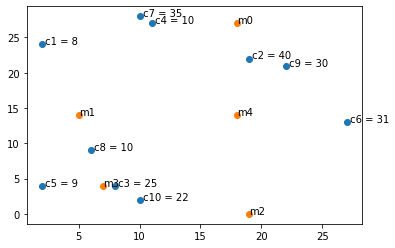

In [235]:
fig, ax = plt.subplots() 
ax.scatter(xc[1:],yc[1:])
ax.scatter(xm,ym)
for i, q in enumerate(demandes.values()):
    ax.annotate(f' c{i+1} = {q}', (xc[i+1],yc[i+1]))
for i in range(nmagasins):
    ax.annotate(f'm{i}', (xm[i],ym[i]))
plt.show()

In [236]:
def ModelInit(arcs, capacité, demandes, distances, N):
    model = Model('CVRP')
    x = model.binary_var_dict(arcs, name = 'x') # variable binaire pour les arcs -> 0 ou 1 en fonction de si on le prend ou pas
    u = model.continuous_var_dict(N, ub = capacité, name = 'u')
    model.minimize(model.sum(distances[i,j]*x[i,j] for i,j in arcs)) # fct objectif = minimiser la distance entre les arcs qui sont pris
    model.add_constraints(model.sum(x[i,j] for j in V if j!=i) == 1 for i in N) # graphe connexe, tous les arcs doivent être liés
    model.add_constraints(model.sum(x[i,j] for i in V if i!=j) == 1 for j in N)
    model.add_indicator_constraints(model.indicator_constraint(x[i, j], u[i]+demandes[j] == u[j]) for i, j in arcs if i != 0 and j != 0)
    model.add_constraints(u[i] >= demandes[i] for i in N)
    model.parameters.timelimit = 60
    return model
  

In [237]:
def solver(model):
    return model.solve(log_output = False)

Définition des arcs d'un noeud i à un noeud j et calcul de distance pour chaque arc

In [238]:
best_value = 10**10
best_magasin = None
best_solution = None
for magasin in range(nmagasins):
    xtot, ytot = add_magasin(xm[magasin],ym[magasin],xc,yc)
    arcs = [(i,j) for i in V for j in V if i!=j]
    distances = {(i,j): np.hypot(xtot[i]-xtot[j],ytot[i]-ytot[j]) for i,j in arcs}
    model = ModelInit(arcs, capacité, demandes, distances, N)
    solution = solver(model)
    value = solution.objective_value
    if value < best_value:
        best_value = value 
        best_magasin = magasin
        best_solution = solution
print(f'La plus petite distance à parcourir est {best_value}')
print(f'Le numéro du meilleur emplacement pour le magasin est {best_magasin}')

La plus petite distance à parcourir est 124.04259069379415
Le numéro du meilleur emplacement pour le magasin est 4


In [239]:
arcs_actifs = []
values = best_solution.as_df()
for i in range(len(values['name'])):
    value = values['name'][i].split('_')
    if value[0] == 'x' and values['value'][i] > 0.95:
        arcs_actifs.append((int(value[1]),int(value[2])))

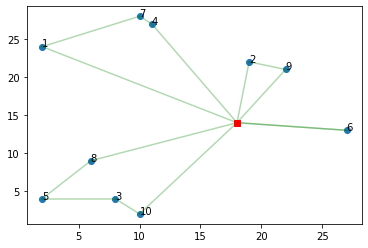

In [241]:
fig, ax = plt.subplots() 
ax.scatter(xc[1:],yc[1:]) # affichage des clients  
for i in N:
    plt.annotate(i, (xc[i], yc[i]))
xc[0],yc[0] = xm[best_magasin],ym[best_magasin]
for i,j in arcs_actifs:
     plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', alpha=0.3)
plt.plot(xm[best_magasin],ym[best_magasin], c='r', marker='s') # affichage du meilleur magasin
plt.show()